In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D 

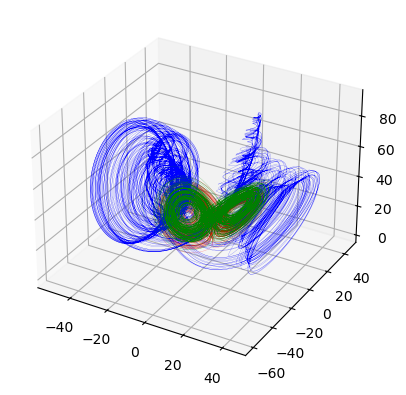

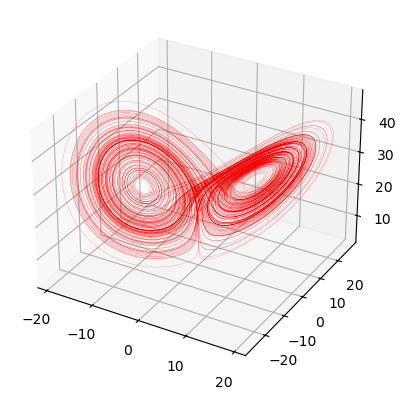

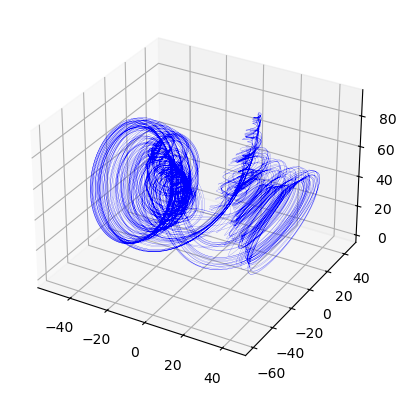

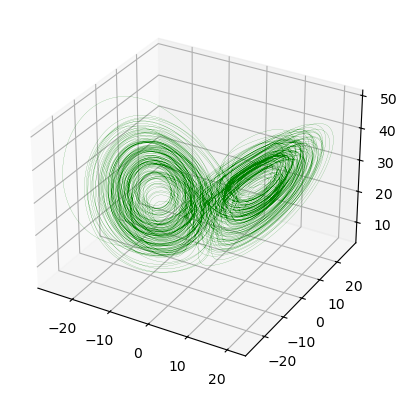

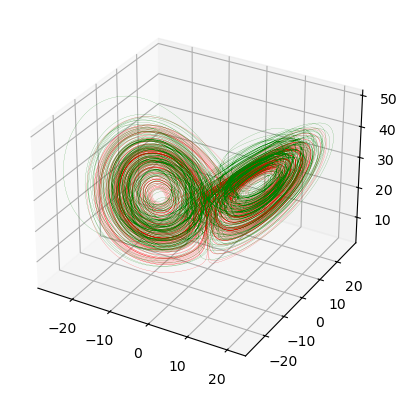

In [5]:
## Lorenz system parameters 
sigma = 10.0
rho = 28.0
beta = 2.66667


## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 100
tau = 10



## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rossler disturbance ###
           
ntest = int(200 / dt)
testingtimes = np.linspace(0, 200, ntest + 1)

gxnocontrol = np.zeros(ntest)
gxcontrol = np.zeros(ntest)
ux = np.zeros(ntest + 1)
vx = np.zeros(ntest + 1)

gynocontrol = np.zeros(ntest)
gycontrol = np.zeros(ntest)
uy = np.zeros(ntest + 1)
vy = np.zeros(ntest + 1)

gznocontrol = np.zeros(ntest)
gzcontrol = np.zeros(ntest)
uz = np.zeros(ntest + 1)
vz = np.zeros(ntest + 1)


## Rossler system parameters

xross = np.zeros(ntest + 1)
yross = np.zeros(ntest + 1)
zross = np.zeros(ntest + 1)

xross[0] = -7.45
yross[0] = -3.03
zross[0] = 0.01


## Storing x, y, z time series data when there is disturbance and control is applied
xcontrol = np.zeros(ntest)             
ycontrol = np.zeros(ntest)
zcontrol = np.zeros(ntest)

## Storing x, y, z time series data when there is disturbance and control is not applied
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## Storing x, y, z time series data if there was no disturbance
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)


xxcontrol, yycontrol, zzcontrol = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpure, yypure, zzpure = x, y, z

temp = Wout.dot(R[:, -1])

for t in range(ntest):

    ## No disturbance and system is evolving with old parameters

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure    
    
    
    ## Disturbance

    xrossdot = - yross[t] - zross[t]
    yrossdot = xross[t] + 0.2 * yross[t]
    zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

    xross[t + 1] = xross[t] + dt * xrossdot
    yross[t + 1] = yross[t] + dt * yrossdot
    zross[t + 1] = zross[t] + dt * zrossdot

    gxnocontrol[t] = xross[t] * 50
    gxcontrol[t] = xross[t] * 50
    gynocontrol[t] = yross[t] * 50
    gycontrol[t] = yross[t] * 50


    ## Disturbance but no control
    
    xxnocontrolp = sigma * (yynocontrol - xxnocontrol) + gxnocontrol[t]
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol


    ## Disturbance with delayed control


    ux[t] = temp[0]
    uy[t] = temp[1]
    uz[t] = temp[2]

    vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
    vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
    vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

    xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
    yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
    zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

    xxcontrol += dt * xxcontrolp
    yycontrol += dt * yycontrolp
    zzcontrol += dt * zzcontrolp

    xcontrol[t] = xxcontrol
    ycontrol[t] = yycontrol
    zcontrol[t] = zzcontrol

    temp = np.array([xxcontrol, yycontrol, zzcontrol])
    r = np.tanh(A.dot(r) + Win.dot(temp) + 1)
    temp = Wout.dot(r)



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1)
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1)
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1)
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1)
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1)
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1)
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1)
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1)
plt.show()


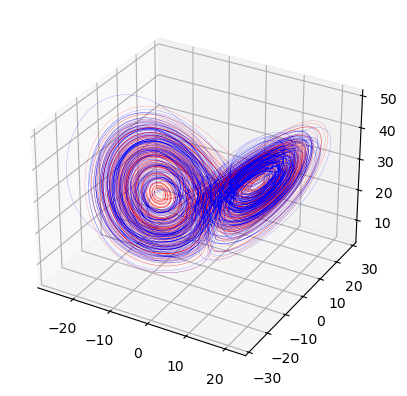

In [29]:
alphaseries = np.array([100])

#alphaseries = np.array([0.01, 1, 100, 1000, 2000, 3000])
avgseries = []
n = 1000  # reservoir size
m = 3

mu = 1.2
lam = 0.000001

tau = 10

# Generate sparse reservoir matrix A1
A1 = sp.random(n, n, density=6/n, format='csr')
A1 = A1 - 0.5 * np.sign(A1.toarray())
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix
A = sp.csr_matrix(A1)

Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

r = 0.5 - 1.0 * np.random.rand(n)

x, y, z = -7.45, -3.03, 0.01

T = 100
dt = 0.002

ntraining = int(T / dt)

R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

for t in range(ntraining):
    
    u = np.array([x, y, z])
    R[:, t] = r

    fx = np.cos(0.05 * dt * t)
    fy = np.sin(0.05 * dt * t)
    f[0, t] = fx
    f[1, t] = fy

    xp = 10 * (y - x) + fx
    yp = x * (28 - z) - y + fy
    zp = x * y - 2.66667 * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))

gtemp = np.array([x, y, z])

ndist = int(200 / dt)

for alpha in alphaseries:
    #np.random.seed(0)

    

    xross = np.zeros(ndist + 1)
    yross = np.zeros(ndist + 1)
    zross = np.zeros(ndist + 1)

    xross[0] = -7.45
    yross[0] = -3.03
    zross[0] = 0.01


    gx = np.zeros(ndist)
    gy = np.zeros(ndist)

    ux = np.zeros(ndist + 1)
    uy = np.zeros(ndist + 1)

    vx = np.zeros(ndist + 1)
    vy = np.zeros(ndist + 1)


    gpredx = np.zeros(ndist)
    gpredy = np.zeros(ndist)

    xplot = np.zeros(ndist)
    yplot = np.zeros(ndist)
    zplot = np.zeros(ndist)

    xplotwithout = np.zeros(ndist)
    yplotwithout = np.zeros(ndist)
    zplotwithout = np.zeros(ndist)

    xwithout, ywithout, zwithout = x, y, z

    for t in range(ndist):

        xrossdot = - yross[t] - zross[t]
        yrossdot = xross[t] + 0.2 * yross[t]
        zrossdot = 0.2 + zross[t] * (xross[t] - 5.7)

        xross[t + 1] = xross[t] + dt * xrossdot
        yross[t + 1] = yross[t] + dt * yrossdot
        zross[t + 1] = zross[t] + dt * zrossdot
    
        gx[t] = xross[t] * 50
        gy[t] = yross[t] * 50

    
        ux[t] = gtemp[0] 
        uy[t] = gtemp[1]



        vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
        vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])

        xp = 10 * (y - x) + gx[t] - alpha * vx[t]
        yp = x * (28 - z) - y + gy[t] - alpha * vy[t]
        zp = x * y - 2.66667 * z

        x += dt * xp
        y += dt * yp
        z += dt * zp
        
        xplot[t] = x
        yplot[t] = y
        zplot[t] = z

        xpwithout = 10 * (ywithout - xwithout) 
        ypwithout = xwithout * (28 - zwithout)
        zpwithout = xwithout * ywithout - 2.66667 * zwithout

        xwithout += dt * xpwithout
        ywithout += dt * ypwithout
        zwithout += dt * zpwithout
        
        xplotwithout[t] = xwithout
        yplotwithout[t] = ywithout
        zplotwithout[t] = zwithout

        gtemp = np.array([x, y, z])
        r = np.tanh(A.dot(r) + Win.dot(gtemp) + 1)
        gtemp = Wout.dot(r)
        gpredx[t] = gtemp[0]
        gpredy[t] = gtemp[1]


#     pwithout = np.vstack((xplotwithout, yplotwithout, zplotwithout))
#     pwith = np.vstack((xplot, yplot, zplot))
#     pwithout = pwithout[:, -5000:]
#     pwith = pwith[:, -5000:]

#     sumdist = 0
#     avg = 0
#     for i in range(pwith.shape[1]):
#         mindist = norm(pwith[:, i] - pwithout[:, 0])
#         for j in range(pwithout.shape[1]):
#             if norm(pwith[:, i] - pwithout[:, j]) < mindist :
#                 mindist = norm(pwith[:, i] - pwithout[:, j])
#         sumdist += mindist

#     avg = sumdist/pwith.shape[1]
#     avgseries.append(avg)

# avgseries = np.array(avgseries)

# fig = plt.figure()
# ax = plt.gca()
# ax.plot(alphaseries ,avgseries, 'o', c='blue', markeredgecolor='none')
# ax.set_yscale('log')
# ax.set_xscale('log')

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xplotwithout, yplotwithout, zplotwithout, 'r', linewidth = 0.1)
#ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1)
ax.plot3D(xplot, yplot, zplot, 'b', linewidth = 0.1)
plt.show()
